In [95]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
sns.set_theme(style="darkgrid")

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingGridSearchCV

import xgboost as xgb
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Lasso
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.multiclass import OneVsOneClassifier,OneVsRestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.linear_model import RidgeClassifier
from sklearn.svm import LinearSVC
from sklearn.ensemble import BaggingClassifier, VotingClassifier
from sklearn.linear_model._perceptron import Perceptron
from sklearn.ensemble import StackingClassifier
from sklearn.feature_selection import SelectKBest, chi2

from sklearn.feature_selection import VarianceThreshold

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.feature_selection import SequentialFeatureSelector

from sklearn.model_selection import learning_curve,cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score,f1_score,recall_score,precision_score
from sklearn.metrics import roc_auc_score

from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

In [84]:
df=pd.read_csv(r'https://archive.ics.uci.edu/ml/machine-learning-databases/00272/SkillCraft1_Dataset.csv')
df.head()

,GameID,LeagueIndex,Age,HoursPerWeek,TotalHours,APM,SelectByHotkeys,AssignToHotkeys,UniqueHotkeys,MinimapAttacks,MinimapRightClicks,NumberOfPACs,GapBetweenPACs,ActionLatency,ActionsInPAC,TotalMapExplored,WorkersMade,UniqueUnitsMade,ComplexUnitsMade,ComplexAbilitiesUsed
0,52,5,27,10,3000,143.7180,0.003515,0.000220,7,0.000110,0.000392,0.004849,32.6677,40.8673,4.7508,28,0.001397,6,0.0,0.000000
1,55,5,23,10,5000,129.2322,0.003304,0.000259,4,0.000294,0.000432,0.004307,32.9194,42.3454,4.8434,22,0.001193,5,0.0,0.000208
2,56,4,30,10,200,69.9612,0.001101,0.000336,4,0.000294,0.000461,0.002926,44.6475,75.3548,4.0430,22,0.000745,6,0.0,0.000189
3,57,3,19,20,400,107.6016,0.001034,0.000213,1,0.000053,0.000543,0.003783,29.2203,53.7352,4.9155,19,0.000426,7,0.0,0.000384
4,58,3,32,10,500,122.8908,0.001136,0.000327,2,0.000000,0.001329,0.002368,22.6885,62.0813,9.3740,15,0.001174,4,0.0,0.000019


Attribute Information:

1. GameID: Unique ID number for each game (integer)
2. LeagueIndex: Bronze, Silver, Gold, Platinum, Diamond, Master, GrandMaster, and Professional leagues coded 1-8 (Ordinal)
3. Age: Age of each player (integer)
4. HoursPerWeek: Reported hours spent playing per week (integer)
5. TotalHours: Reported total hours spent playing (integer)
6. APM: Action per minute (continuous)
7. SelectByHotkeys: Number of unit or building selections made using hotkeys per timestamp (continuous)
8. AssignToHotkeys: Number of units or buildings assigned to hotkeys per timestamp (continuous)
9. UniqueHotkeys: Number of unique hotkeys used per timestamp (continuous)
10. MinimapAttacks: Number of attack actions on minimap per timestamp (continuous)
11. MinimapRightClicks: number of right-clicks on minimap per timestamp (continuous)
12. NumberOfPACs: Number of PACs per timestamp (continuous)
13. GapBetweenPACs: Mean duration in milliseconds between PACs (continuous)
14. ActionLatency: Mean latency from the onset of a PACs to their first action in milliseconds (continuous)
15. ActionsInPAC: Mean number of actions within each PAC (continuous)
16. TotalMapExplored: The number of 24x24 game coordinate grids viewed by the player per timestamp (continuous)
17. WorkersMade: Number of SCVs, drones, and probes trained per timestamp (continuous)
18. UniqueUnitsMade: Unique unites made per timestamp (continuous)
19. ComplexUnitsMade: Number of ghosts, infestors, and high templars trained per timestamp (continuous)
20. ComplexAbilitiesUsed: Abilities requiring specific targeting instructions used per timestamp (continuous)

In [85]:
ind = df[ df['LeagueIndex'] ==8].index
df.drop(ind , inplace=True)
ind = df[ df['TotalHours'] =='?'].index
df.drop(ind , inplace=True)
df["Age"]=df["Age"].astype('int')
df["TotalHours"]=df["TotalHours"].astype('int')
df["HoursPerWeek"]=df["HoursPerWeek"].astype('int')

In [86]:

df['Ratio_units']=df['UniqueUnitsMade']/df['APM']

df['Total_Latency']=df['APM']*df['ActionLatency']
df['Total_pac']=df['ActionsInPAC']*df['NumberOfPACs']
#df['Ratio_map']=df['TotalMapExplored']/df['TotalHours']
df['Ratio_speed']=(df['SelectByHotkeys']+df['AssignToHotkeys']+df['UniqueHotkeys']
                  )/(df['ActionLatency']+df['GapBetweenPACs'])
df['PacByWorkers']=(df['NumberOfPACs']
                  )*(df['WorkersMade'])
df['Quick']=(df['ActionsInPAC']+df['APM'])/(df['ActionLatency']+df['GapBetweenPACs'])
df['LogTotalHours']=np.log(df['TotalHours'])
#df['LogSelect']=np.log(df['SelectByHotkeys'])
df['LogTotalPac']=np.log(df['Total_pac'])
df['LogPacByWorkers']=np.log(df['PacByWorkers'])
df['LogQuick']=np.log(df['Quick'])

<AxesSubplot:xlabel='PacByWorkers', ylabel='Density'>

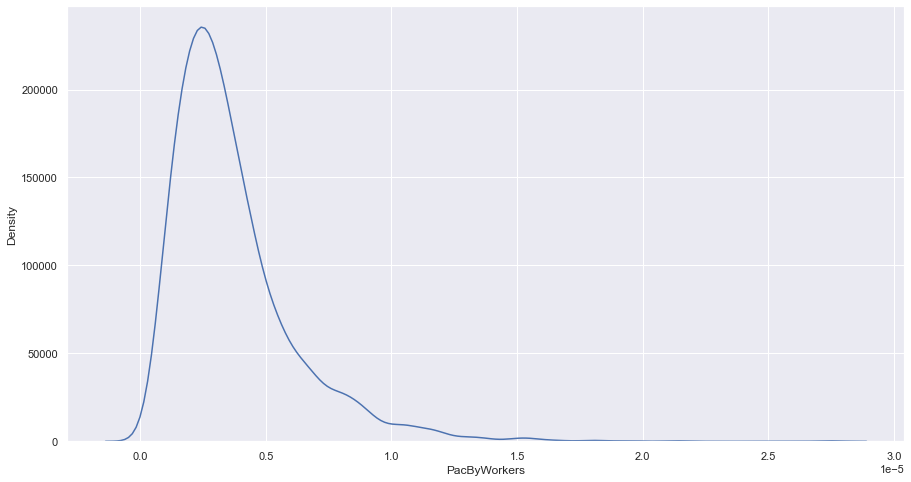

In [35]:
sns.kdeplot(x='PacByWorkers',data=df)

In [87]:
col_name = df.columns.to_series()[np.isinf(df).any()]
print(col_name)

Series([], dtype: object)


In [88]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3338 entries, 0 to 3339
Data columns (total 30 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   GameID                3338 non-null   int64  
 1   LeagueIndex           3338 non-null   int64  
 2   Age                   3338 non-null   int32  
 3   HoursPerWeek          3338 non-null   int32  
 4   TotalHours            3338 non-null   int32  
 5   APM                   3338 non-null   float64
 6   SelectByHotkeys       3338 non-null   float64
 7   AssignToHotkeys       3338 non-null   float64
 8   UniqueHotkeys         3338 non-null   int64  
 9   MinimapAttacks        3338 non-null   float64
 10  MinimapRightClicks    3338 non-null   float64
 11  NumberOfPACs          3338 non-null   float64
 12  GapBetweenPACs        3338 non-null   float64
 13  ActionLatency         3338 non-null   float64
 14  ActionsInPAC          3338 non-null   float64
 15  TotalMapExplored     

In [89]:
def deleteOutliers(df):
    col = df.columns
    IsoForest = IsolationForest(contamination=0.03)
    IsoForest.fit(df[col])
    outliersIso = IsoForest.predict(df[col]) == -1
    df['OutlierIso'] = outliersIso
    
    LocalOut = LocalOutlierFactor(n_neighbors=4)
    outliersLocal = LocalOut.fit_predict(df[col]) == -1
    df['OutlierLocal'] = outliersLocal
    
    ind = df[df['OutlierLocal'] == True][df['OutlierIso'] == True].index
    print('We deleted ',len(ind), ' outliers')
    df.drop(ind , inplace=True)
    df=df.drop(columns=['OutlierLocal','OutlierIso'])
    return df

def bestCorrelated(df,target_column,pct_limit):
    target=df.columns[target_column]
    correlation=df.corr()
    x=pd.DataFrame(correlation.iloc[target_column].abs().sort_values(ascending=False))
    x=x[x[target]>=pct_limit]
    return x

def topFeatures(df,target_column,pct_limit):
    target=df.columns[target_column]
    correlation=df.corr()
    x=pd.DataFrame(correlation.iloc[target_column].abs())
    x=x[x[target]>=pct_limit]
    col=list(df.columns)
    #print (x.index)
    df=df[x.index]
    return df

def cor_matrix(df,target_column,pct_limit):
    x=bestCorrelated(df,target_column,pct_limit)
    top=x.index
    cor=df[top].corr().abs()
    sns.set(rc = {'figure.figsize':(15,8)})
    sns.heatmap(cor,
            cmap='autumn',
            annot=True,
            vmax=1,
            vmin=0,
            linewidths=0,
            #cbar_kws ={"orientation":"horizontal"}
           )

def dataSplit(df,testSize,target):
    col = list(df.columns)
    col.remove(target)
    X = df[col].values
    y = df[target].values
    X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = testSize)
    return X_train,X_test,y_train,y_test

def create_PCA(X_train,n_dims):
    #n_dims = X_train.shape[1]
    model = PCA(n_components=n_dims)
    model.fit(X_train)
    return model

def display_scree_plot(pca):
    '''Display a scree plot for the pca'''

    scree = pca.explained_variance_ratio_*100
    plt.bar(np.arange(len(scree))+1, scree,label='Variance explained by each feature')
    plt.plot(np.arange(len(scree))+1, scree.cumsum(),c="red",marker='o',label='Cumulated variance')
    line = plt.axhline(94,color='black',ls='--',label ='95% explained variance',alpha=0.5)
    plt.xlabel("Number of principal components")
    plt.ylabel("Percentage explained variance")
    plt.title("Scree plot")
    plt.legend()
    plt.show(block=False)
  
def indiv_plot_pca(X_train,model_pca):
    X_train_pca = model_pca.transform(X_train)
    plt.scatter(X_train_pca[:,0], X_train_pca[:,1],c=y_train,cmap='hot')
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.colorbar()
    
def bestPara(params,model,X,Y):
    grid=GridSearchCV(model,params,n_jobs=-1,cv=5,verbose=1)
    grid.fit(X[0],Y)
    #print('Score : ',grid.best_score_*100,'%')
    print('Best estimator : ',grid.best_estimator_)
    model=grid.best_estimator_
    #N,train_score,val_score=learning_curve(model,X,Y,train_sizes=np.linspace(0.2,1.0,10),cv=3)
    scores={}
    i=1
    for a in X:
        model.fit(a,Y)
        name='X_train'+str(i)
        temp=np.mean(cross_val_score(model,a,Y,cv=3))
        scores[name]=temp
        i+=1
    results=pd.DataFrame(list(scores.items()),columns=['X_set','Accuracy'])
    results['Accuracy']=results['Accuracy']*100
    top=max(results['Accuracy'])
    sns.barplot(x='Accuracy',y='X_set',data=results,color="b",palette="Blues_d")
    print('Best score : ', top,'%', ' with this training set : ',
                               results['X_set'][results['Accuracy']==top])
    #plt.plot(N,train_score.mean(axis=1),label='train')
    #plt.plot(N,val_score.mean(axis=1),label='validation',marker="o")
    #plt.xlabel('train sizes')
    #plt.legend()
    return top
    

def resultsClassification(model,X_train,Y_train,X_test,Y_test):
    model.fit(X_train,Y_train)
    y_pred = model.predict(X_test)
    print("Accuracy Score:",round(accuracy_score(Y_test,y_pred),5))
    print ('F1 score:', round(f1_score(Y_test, y_pred,average='weighted'),5))
    print ('Recall:', round(recall_score(Y_test, y_pred,average='weighted'),5))
    print ('Precision:', round(precision_score(Y_test, y_pred,zero_division=0,average='weighted'),5))
    #print('AUC:',roc_auc_score(Y_test,model.decision_function(X_train),multi_class='ovr'))
    conf_matrix(Y_test,y_pred)
    plt.xlabel('Predicted label', fontsize = 15) 
    plt.ylabel('True label', fontsize = 15) 

def conf_matrix(y,y_pred):
    cf_matrix = confusion_matrix(y, y_pred)
    size=np.shape(cf_matrix)[0]
    sns.set(rc = {'figure.figsize':(15,8)})
    group_counts = ["{0:0.0f}".format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f"{v2}\n{v3}" for v2, v3 in
              zip(group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(size,size)
    sns.heatmap(cf_matrix,annot=labels, fmt="", cmap='autumn')
    
def allModels(acc_dict):
    acc_dict=dict(sorted(acc_dict.items(), key=lambda item: item[1]))
    result_models=pd.DataFrame(list(acc_dict.items()),columns=['Classifier', 'Accuracy'])
    plt.title('Classifier Accuracy')
    sns.barplot(x='Accuracy', y='Classifier', data=result_models, color="b",palette="Blues_d")
    
def featureSelection(model,n_features,X_train,y_train):
        
    sfs=SequentialFeatureSelector(model,n_features_to_select=n_features,cv=3,scoring='accuracy',direction='forward')
    sfs.fit(X_train, y_train)
    indices = [i for i, x in enumerate(list(sfs.get_support())) if x == True]
    #col = list(df.columns)
    #col.remove(target)
    #print("We keep the following features : ")
    #for a in indices:
        #print (col[a])
    
    return indices

def affichageFeatures(idx,df,target):
    col = list(df.columns)
    col.remove(target)
    print("We keep the following features : ")
    for a in indices:
        print (col[a])
    

def numberFeatures(model,X_train,y_train):
    scaler= StandardScaler()
    scaler.fit(X_train)
    copy = scaler.fit_transform(X_train)
    maxFeatures=X_train.shape[1]
    res={}
    for i in range(1,int(0.7*maxFeatures)):
        print('step= ',i)
        cop=copy.copy()
        idx=featureSelection(model,i,copy,y_train)
        cop=cop[:,idx]
        model.fit(cop,y_train)
        temp=np.mean(cross_val_score(model,cop,y_train,cv=2))
        res[str(i)]=temp
    results=pd.DataFrame(list(res.items()),columns=['n_features','Accuracy'])
    results['Accuracy']=results['Accuracy']*100
    #results.plot(y='Accuracy',x='n_features',ylabel='Accuracy',xlabel='n_features')
    results['Accuracy']
    top=max(results['Accuracy'])
    best=results['n_features'][results['Accuracy']==top]
    print('Best score : ', top,'%', ' with this n_features : ',
                               max(best))
 
    
    return max(best)

def dropEmptyElements(threshold,df):
    #Dropping columns with missing value rate higher than threshold
    df = df[df.columns[df.isnull().mean() < threshold]]

    #Dropping rows with missing value rate higher than threshold
    df = df.loc[df.isnull().mean(axis=1) < threshold]
    return df
    
def dropConstantFeatures(threshold,df):
    var_threshold = VarianceThreshold(threshold=threshold)
    var_threshold.fit(df)
    var_threshold.transform(df)
    print("Earlier shape of data: ", df.shape)
    print("Shape after transformation: ", var_threshold.transform(df).shape)
    df=var_threshold.transform(df)
    return df
    

In [90]:
df=deleteOutliers(df)

We deleted  11  outliers


<AxesSubplot:xlabel='LeagueIndex', ylabel='count'>

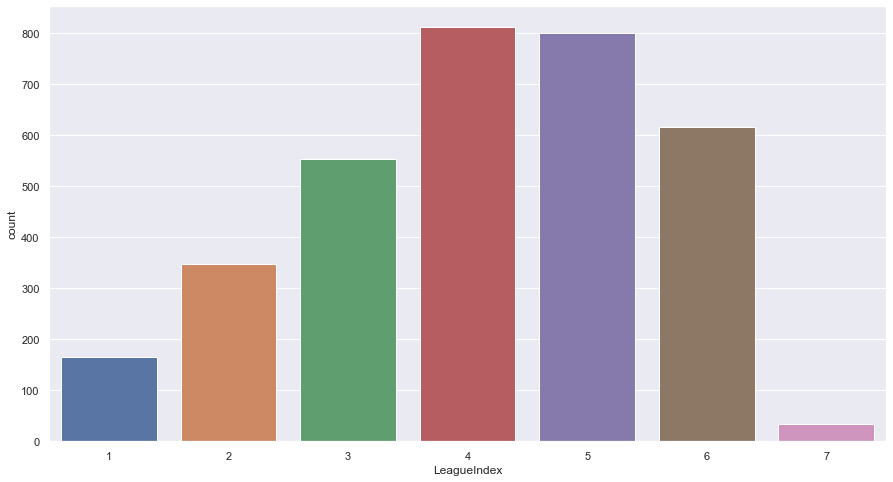

In [91]:
plt.figure(figsize=(15,8))
sns.countplot(x='LeagueIndex',data=df)

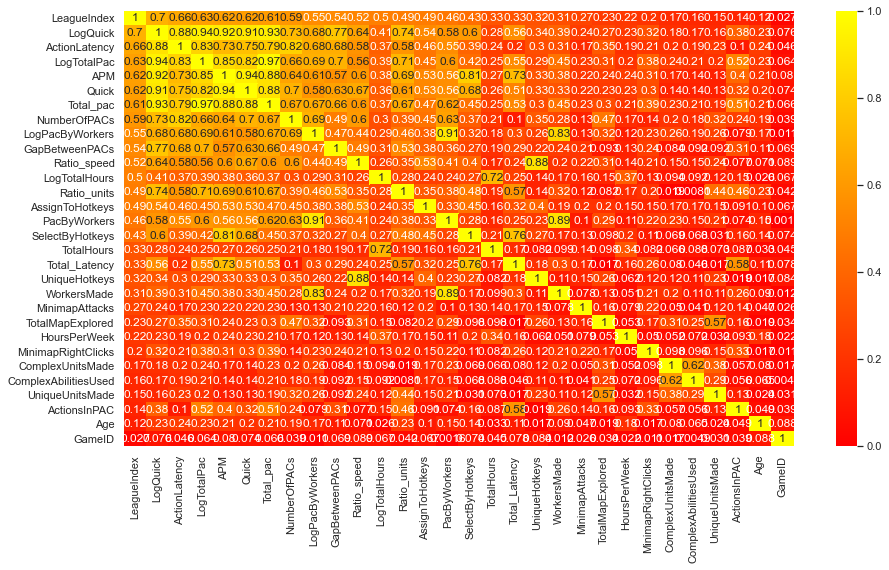

In [92]:
cor_matrix(df,1,0)

In [93]:
df=topFeatures(df,1,0.4)
df.head()

,LeagueIndex,APM,SelectByHotkeys,AssignToHotkeys,NumberOfPACs,GapBetweenPACs,ActionLatency,Ratio_units,Total_pac,Ratio_speed,PacByWorkers,Quick,LogTotalHours,LogTotalPac,LogPacByWorkers,LogQuick
0,5,143.7180,0.003515,0.000220,0.004849,32.6677,40.8673,0.041748,0.023037,0.095244,0.000007,2.019022,8.006368,-3.770662,-11.902690,0.702613
1,5,129.2322,0.003304,0.000259,0.004307,32.9194,42.3454,0.038690,0.020861,0.053193,0.000005,1.781385,8.517193,-3.869882,-12.178364,0.577391
2,4,69.9612,0.001101,0.000336,0.002926,44.6475,75.3548,0.085762,0.011829,0.033345,0.000002,0.616690,5.298317,-4.437216,-13.036933,-0.483389
3,3,107.6016,0.001034,0.000213,0.003783,29.2203,53.7352,0.065055,0.018593,0.012070,0.000002,1.356355,5.991465,-3.984963,-13.337958,0.304801
4,3,122.8908,0.001136,0.000327,0.002368,22.6885,62.0813,0.032549,0.022200,0.023611,0.000003,1.560282,6.214608,-3.807643,-12.792496,0.444867


# Models

In [94]:
X_train,X_test,y_train,y_test=dataSplit(df,0.3,'LeagueIndex')

In [151]:
idx=featureSelection(QuadraticDiscriminantAnalysis(reg_param=0.7, store_covariance=True),int(r),X_train,y_train,'LeagueIndex',df)

In [152]:
X_train=X_train[:,idx]
X_test=X_test[:,idx]

In [153]:
X_train.shape

(2328, 11)

In [14]:
def allScalers(X_train,X_test):
    scaler= StandardScaler()
    scaler.fit(X_train)
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)

    scaler2=MinMaxScaler()
    scaler2.fit(X_train)
    X_train2 = scaler2.fit_transform(X_train)
    X_test2 = scaler2.transform(X_test)

    scaler3=RobustScaler()
    scaler3.fit(X_train)
    X_train3 = scaler3.fit_transform(X_train)
    X_test3 = scaler3.transform(X_test)

    scaler4=MaxAbsScaler()
    scaler4.fit(X_train)
    X_train4 = scaler4.fit_transform(X_train)
    X_test4 = scaler4.transform(X_test)

    scaler5=Normalizer()
    scaler5.fit(X_train)
    X_train5 = scaler5.fit_transform(X_train)
    X_test5 = scaler5.transform(X_test)

    scaler6=QuantileTransformer(output_distribution="uniform")
    scaler6.fit(X_train)
    X_train6 = scaler6.fit_transform(X_train)
    X_test6 = scaler6.transform(X_test)

    scaler7=QuantileTransformer(output_distribution='normal')
    scaler7.fit(X_train)
    X_train7 = scaler7.fit_transform(X_train)
    X_test7 = scaler7.transform(X_test)

    scaler8= PowerTransformer(method="yeo-johnson")
    scaler8.fit(X_train)
    X_train8 = scaler8.fit_transform(X_train)
    X_test8 = scaler8.transform(X_test)


    allSets=[]
    allSets.append(X_train)
    allSets.append(X_train2)
    allSets.append(X_train3)
    allSets.append(X_train4)
    allSets.append(X_train5)
    allSets.append(X_train6)
    allSets.append(X_train7)
    allSets.append(X_train8)
    
    allTest=[]
    allTest.append(X_test)
    allTest.append(X_test2)
    allTest.append(X_test3)
    allTest.append(X_test4)
    allTest.append(X_test5)
    allTest.append(X_test6)
    allTest.append(X_test7)
    allTest.append(X_test8)
    
    return allSets, allTest
    




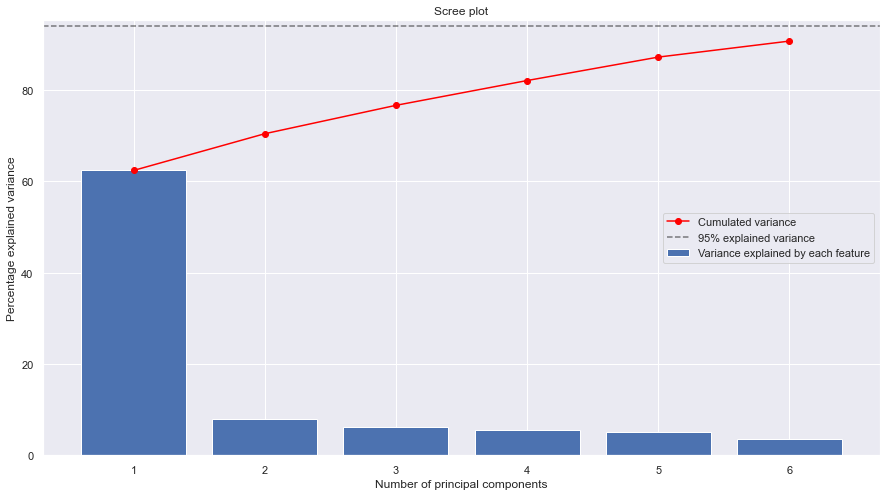

In [125]:
model=create_PCA(X_train,6)
display_scree_plot(model)

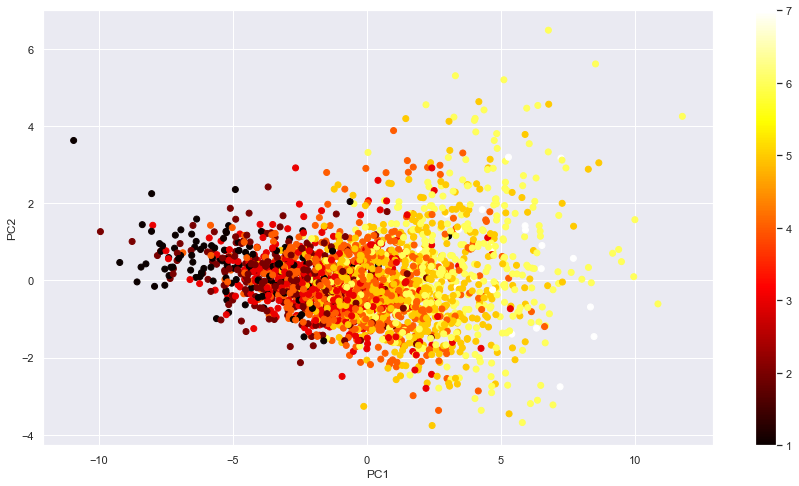

In [126]:
indiv_plot_pca(X_train,model)

In [96]:
acc_dict={}

step=  1
step=  2
step=  3
step=  4
step=  5
step=  6
step=  7
step=  8
step=  9
Best score :  39.931492706812385 %  with this n_features :  4
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best estimator :  QuadraticDiscriminantAnalysis(reg_param=0.85, store_covariance=True)
Best score :  42.077921072766436 %  with this training set :  6    X_train7
Name: X_set, dtype: object


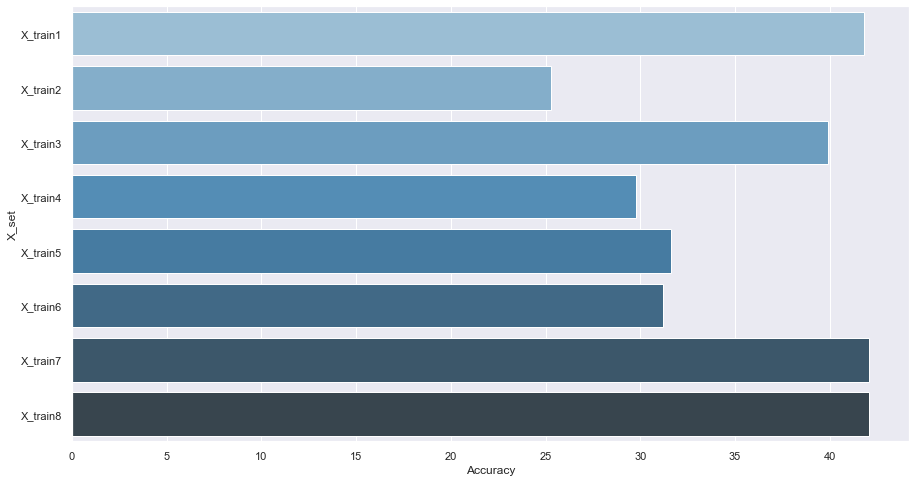

In [63]:
n=numberFeatures(QuadraticDiscriminantAnalysis(),X_train,y_train)
idx=featureSelection(QuadraticDiscriminantAnalysis(),int(n),X_train,y_train)
copytrain=X_train[:,idx]
copytest=X_test[:,idx]
allSets,allTest=allScalers(copytrain,copytest)

parameters = {
           'reg_param': [0.85,0.935,0.87,1,0.8,0.7],
            'store_covariance':[True,False]
}
top=bestPara(parameters,QuadraticDiscriminantAnalysis(),allSets,y_train)
acc_dict["QuadraticDiscriminantAnalysis"]=top

step=  1
step=  2
step=  3
step=  4
step=  5
step=  6
step=  7
step=  8
step=  9
Best score :  43.108933233042784 %  with this n_features :  6
Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best estimator :  BaggingClassifier(base_estimator=QuadraticDiscriminantAnalysis(reg_param=1,
                                                               store_covariance=True),
                  n_estimators=5)
Best score :  40.918458959696075 %  with this training set :  2    X_train3
Name: X_set, dtype: object


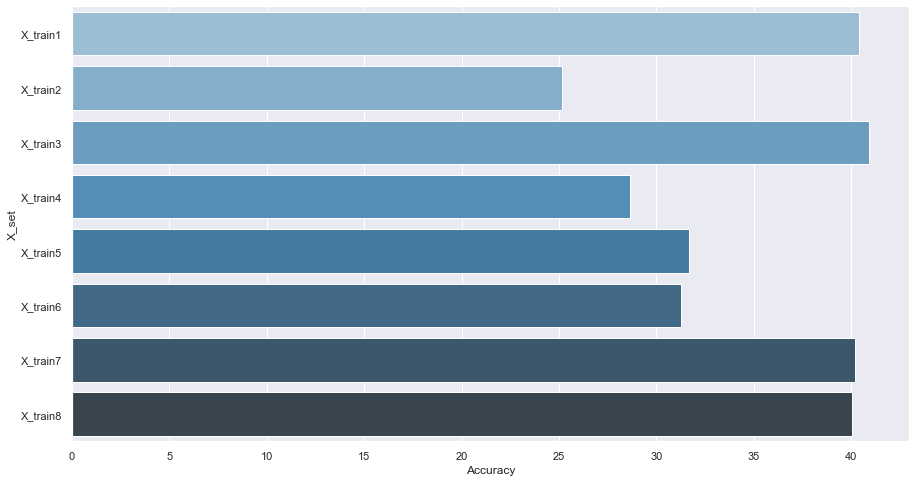

In [65]:
clf=BaggingClassifier(base_estimator=QuadraticDiscriminantAnalysis(reg_param=1, store_covariance=True))
n=numberFeatures(clf,X_train,y_train)
idx=featureSelection(clf,int(n),X_train,y_train)
copytrain=X_train[:,idx]
copytest=X_test[:,idx]
allSets,allTest=allScalers(copytrain,copytest)
parameters={
        'n_estimators':range(1,11)
}

top=bestPara(parameters,clf,allSets,y_train)
acc_dict["QuadraticBagged"]=top

14
Fitting 5 folds for each of 228 candidates, totalling 1140 fits
Best estimator :  KNeighborsClassifier(leaf_size=1, metric='euclidean', n_neighbors=19, p=1,
                     weights='distance')
Best score :  41.51988881370325 %  with this training set :  7    X_train8
Name: X_set, dtype: object


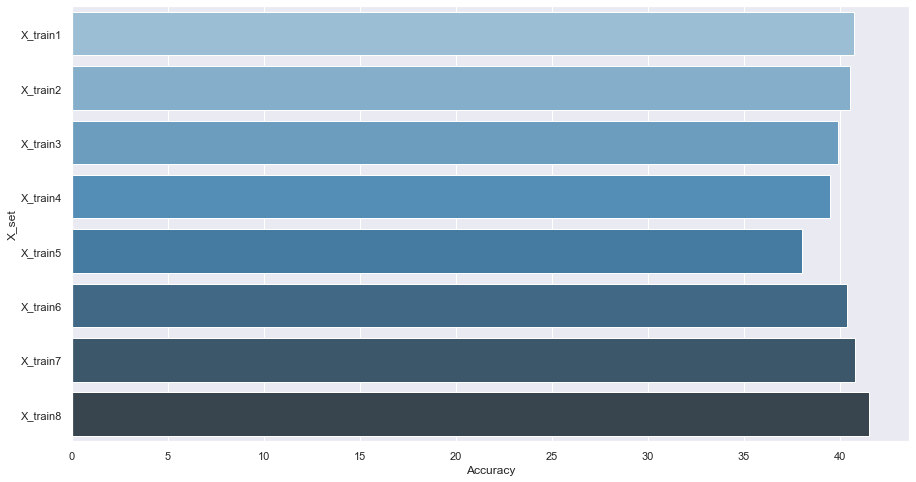

In [72]:
#n=numberFeatures(KNeighborsClassifier(),X_train,y_train)
#idx=featureSelection(KNeighborsClassifier(),int(n),X_train,y_train)
idx=X_train.shape[1]-1
copytrain=X_train[:,:idx]
copytest=X_test[:,:idx]
allSets,allTest=allScalers(copytrain,copytest)
parameters={
            'weights':['uniform','distance'],
            'metric' : ['manhattan','euclidean','minkowski'],
            'leaf_size': [1], 
            'n_neighbors': list(range(1,20)), 
            'p': [1, 2]
           }
top=bestPara(parameters,KNeighborsClassifier(),allSets,y_train)
acc_dict["KNeighborsClassifier"]=top

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best estimator :  GaussianNB()
Best score :  37.371134020618555 %  with this training set :  0    X_train1
1    X_train2
2    X_train3
3    X_train4
Name: X_set, dtype: object


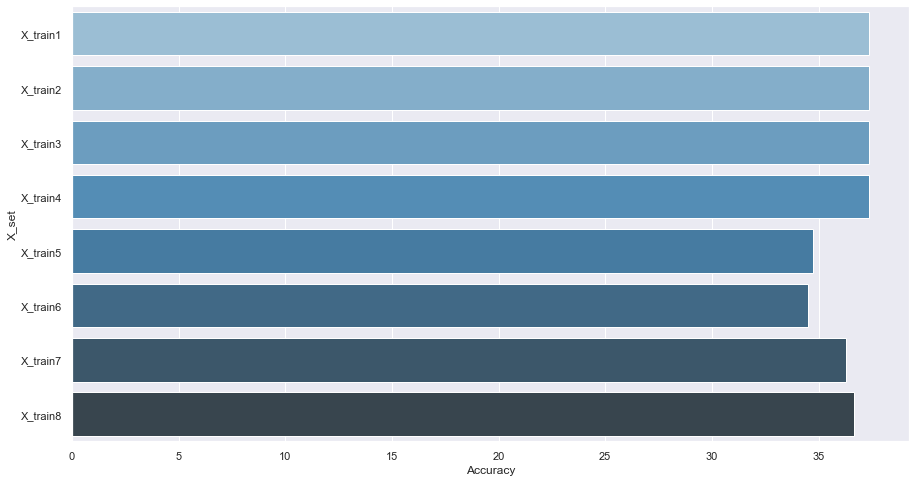

In [156]:
parameters = {
                'priors':[None],
                'var_smoothing':[1e-09]
}
top=bestPara(parameters,GaussianNB(),allSets,y_train)
acc_dict["GaussianNB"]=top

Fitting 5 folds for each of 5600 candidates, totalling 28000 fits
Best estimator :  DecisionTreeClassifier(max_depth=5, max_features='sqrt', max_leaf_nodes=30,
                       min_samples_leaf=5, min_weight_fraction_leaf=0.1)
Best score :  37.140767424272575 %  with this training set :  7    X_train8
Name: X_set, dtype: object


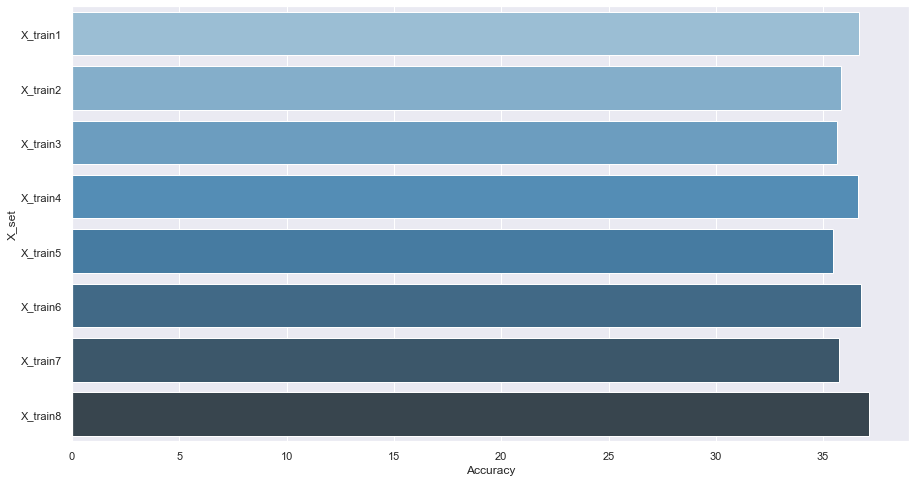

In [132]:
parameters={
            #'splitter':["best","random"],
            'max_depth':[4,5,6,7,8,9,10],
            "min_samples_leaf":[1,2,3,4,5,6,7,8,9,10],
            "min_weight_fraction_leaf":[0.1,0.2],
            "max_features":["auto","log2","sqrt",None],
            "max_leaf_nodes":[None,10,20,30,40,50,60,70,80,90] 
           }
top=bestPara(parameters,DecisionTreeClassifier(),allSets,y_train)
acc_dict["DecisionTreeClassifier"]=top

Fitting 5 folds for each of 6 candidates, totalling 30 fits
Best estimator :  LinearDiscriminantAnalysis()
Best score :  41.1512027491409 %  with this training set :  7    X_train8
Name: X_set, dtype: object


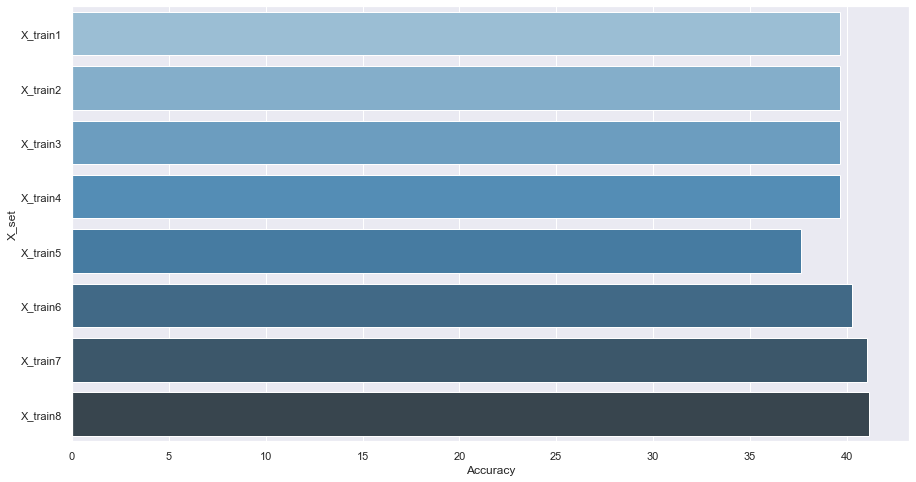

In [134]:
parameters = {
                'solver': ['svd', 'lsqr', 'eigen'],
                'shrinkage':['auto',None]
            }
top=bestPara(parameters,LinearDiscriminantAnalysis(),allSets,y_train)
acc_dict["LinearDiscriminantAnalysis"]=top

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best estimator :  AdaBoostClassifier(base_estimator=LogisticRegression(C=0.6), n_estimators=20)
Best score :  40.67869415807561 %  with this training set :  0    X_train1
Name: X_set, dtype: object


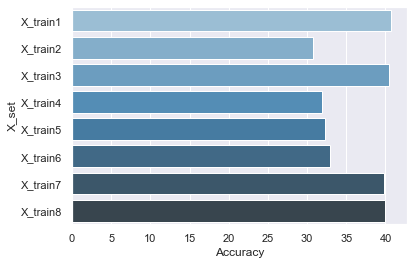

In [67]:
clf=LogisticRegression()
ada = AdaBoostClassifier(clf)
parameters = {'base_estimator__C' :[0.6],
              'n_estimators' :[ 20],
              #'learning_rate' :[0.0001, 0.001, 0.01, 0.1, 1]
             }
top=bestPara(parameters,ada,allSets,y_train)
acc_dict["AdaBoost"]=top

Fitting 5 folds for each of 15 candidates, totalling 75 fits
Best estimator :  SVC(C=1.15, gamma='auto')
Best score :  42.765372146815444 %  with this training set :  7    X_train8
Name: X_set, dtype: object


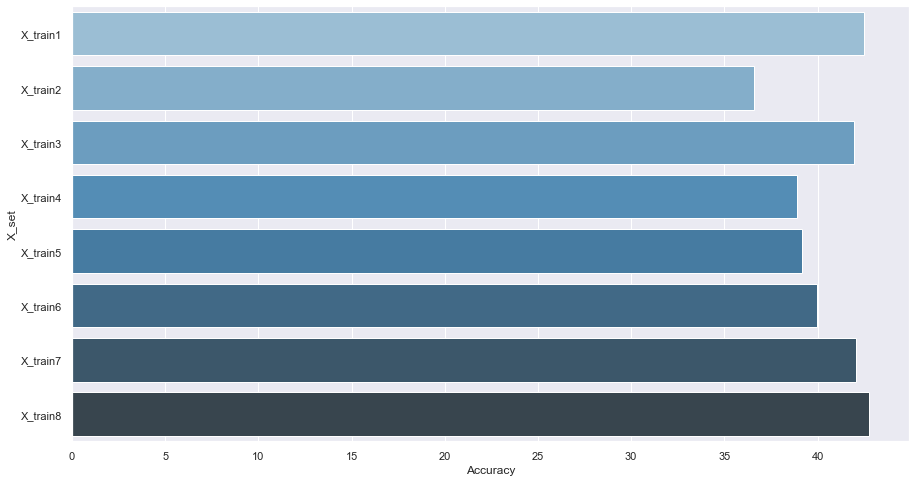

In [75]:
clf=SVC()
#n=numberFeatures(clf,X_train,y_train)
#idx=featureSelection(clf,int(n),X_train,y_train)
idx=X_train.shape[1]-1
copytrain=X_train[:,:idx]
copytest=X_test[:,:idx]
allSets,allTest=allScalers(copytrain,copytest)
parameters = {
                'C': [1.2,1.25, 1.15], 
                'gamma': [0.11,0.1,0.09,'scale','auto'],
                #'kernel': ['rbf', 'poly', 'sigmoid'],
                #'gamma':['scale','auto']
            }
top=bestPara(parameters,SVC(),allSets,y_train)
acc_dict["SVC"]=top

Fitting 5 folds for each of 144 candidates, totalling 720 fits
Best estimator :  RandomForestClassifier(max_features=5, min_samples_split=4, n_estimators=25)
Best score :  39.15806454466249 %  with this training set :  7    X_train8
Name: X_set, dtype: object


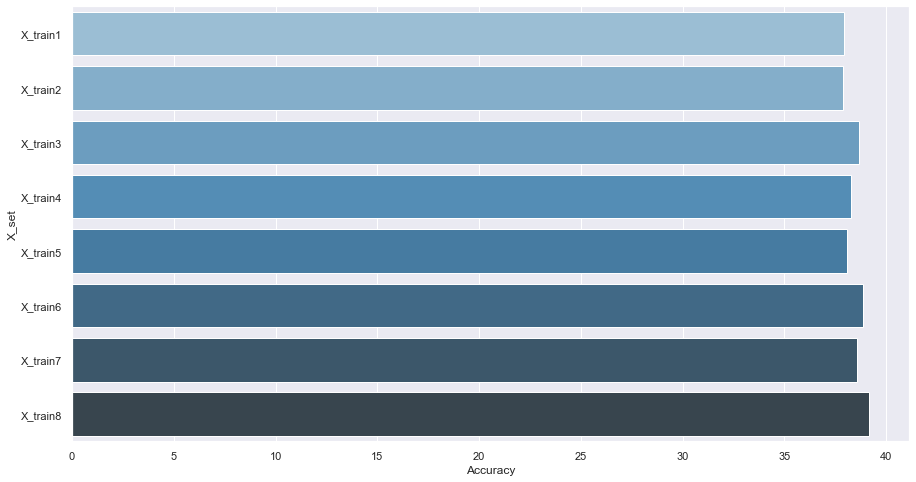

In [135]:
parameters={
            'n_estimators': [10,15,20, 25], 
            'max_features': [3,4,5,6], 
            'max_depth': [60,65, None], 
            #'bootstrap': [True, False],
            #'min_samples_leaf': [1, 2, 4],
            'min_samples_split': [4, 5, 6]
           }
top=bestPara(parameters,RandomForestClassifier(),allSets,y_train)
acc_dict["RandomForestClassifier"]=top

Fitting 5 folds for each of 160 candidates, totalling 800 fits
Best estimator :  LogisticRegression(penalty='l1', solver='saga')
Best score :  43.02266183709483 %  with this training set :  0    X_train1
Name: X_set, dtype: object


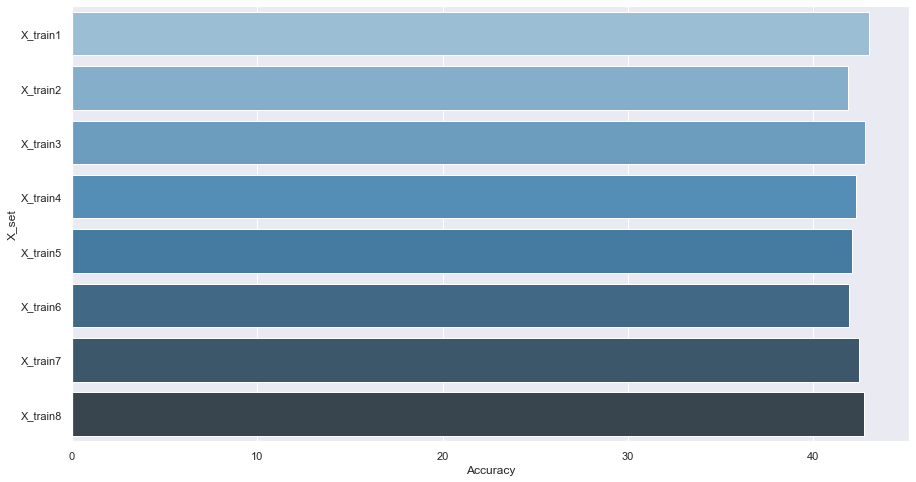

In [76]:
idx=X_train.shape[1]-1
copytrain=X_train[:,:idx]
copytest=X_test[:,:idx]
allSets,allTest=allScalers(copytrain,copytest)
parameters={
            'solver' : ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga'],
            'penalty' : ['l2','l1', 'elasticnet', 'none'],
            'C' : [100, 10, 1.0,8],
            'class_weight':[None,'balanced'],
            #'fit_intercept':[True,False],
            #'multi_class':['auto', 'ovr', 'multinomial']
           }
top=bestPara(parameters,LogisticRegression(),allSets,y_train)
acc_dict["LogisticRegression"]=top

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best estimator :  GradientBoostingClassifier(max_depth=1)
Best score :  41.0907225340215 %  with this training set :  1    X_train2
3    X_train4
5    X_train6
6    X_train7
Name: X_set, dtype: object


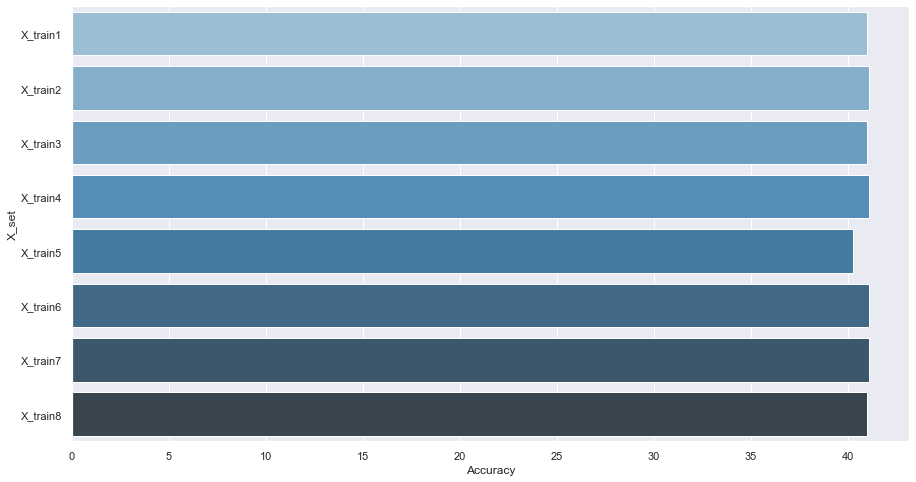

In [142]:
parameters={
            #'loss':['deviance','exponential'],
            #'criterion':['friedman_mse', 'squared_error', 'mse', 'mae'],
            'max_depth':[1,3,5],
            #'max_features':['auto', 'sqrt', 'log2'],
            'min_samples_leaf':[1,2,3]
}

top=bestPara(parameters,GradientBoostingClassifier(),allSets,y_train)
acc_dict["GradientBoostingClassifier"]=top

Fitting 5 folds for each of 40 candidates, totalling 200 fits
Best estimator :  ExtraTreesClassifier(min_samples_split=35, n_estimators=91)
Best score :  41.04771192400058 %  with this training set :  0    X_train1
Name: X_set, dtype: object


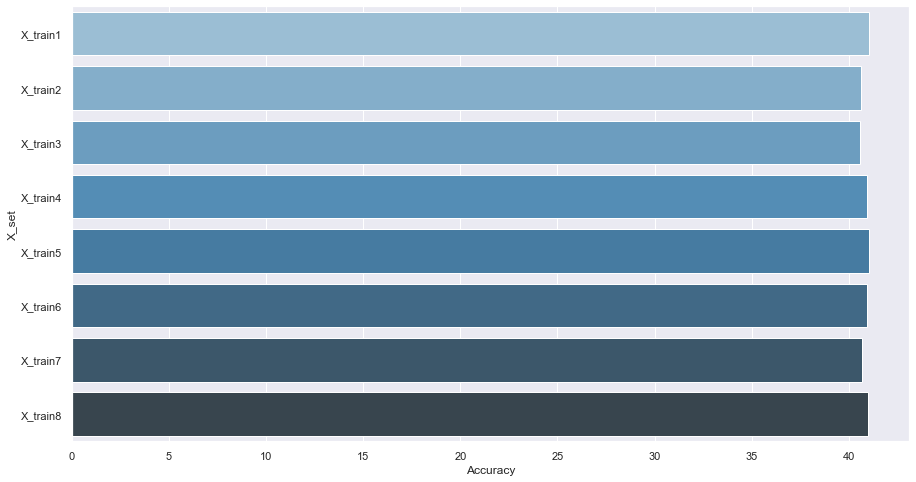

In [141]:
parameters={
            'n_estimators': range(1,100,10),
            #'max_features': range(1,8),
            #'min_samples_leaf': range(20,45,5),
            'min_samples_split': range(20,36,5),
           }
top=bestPara(parameters,ExtraTreesClassifier(),allSets,y_train)
acc_dict["ExtraTrees"]=top

Fitting 5 folds for each of 48 candidates, totalling 240 fits
Best estimator :  RidgeClassifier(alpha=0.635, solver='lsqr')
Best score :  41.19415807560138 %  with this training set :  1    X_train2
Name: X_set, dtype: object


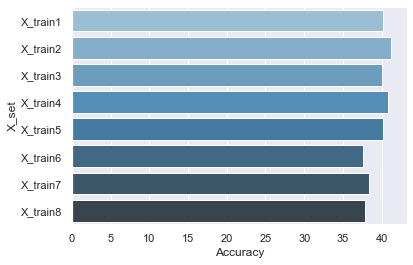

In [69]:
parameters={
            'alpha':[0.635, 0.63,0.64],
            #'fit_intercept':[True,False],
            'normalize':[True,False],
            #'class_weight':['balanced',None],
            'solver':['auto', 'svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga', 'lbfgs'],
            #'positive':[True,False]  only if solver =lbfgs
           }
top=bestPara(parameters, RidgeClassifier(),allSets,y_train)
acc_dict["RidgeClassifier"]=top

Fitting 5 folds for each of 24 candidates, totalling 120 fits
Best estimator :  LinearSVC(C=0.0055)
Best score :  42.396907216494846 %  with this training set :  2    X_train3
Name: X_set, dtype: object


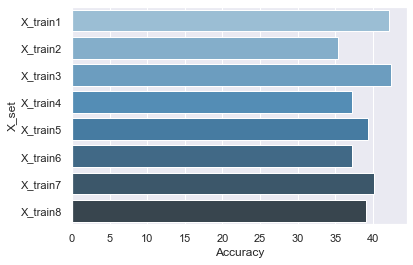

In [70]:
parameters={
            'penalty':['l1', 'l2'],
            'loss':['hinge', 'squared_hinge'], 
            #'dual':[True,False],
            'C':[0.005,0.0055,0.0045],
            'multi_class':['ovr','crammer_singer'],
            #'fit_intercept':[True,False],
            #'class_weight':['balanced',None]
           }
top=bestPara(parameters, LinearSVC(),allSets,y_train)
acc_dict["LinearSVC"]=top

Fitting 5 folds for each of 3 candidates, totalling 15 fits
Best estimator :  Perceptron(penalty='l2')
Best score :  32.287257802721726 %  with this training set :  2    X_train3
Name: X_set, dtype: object


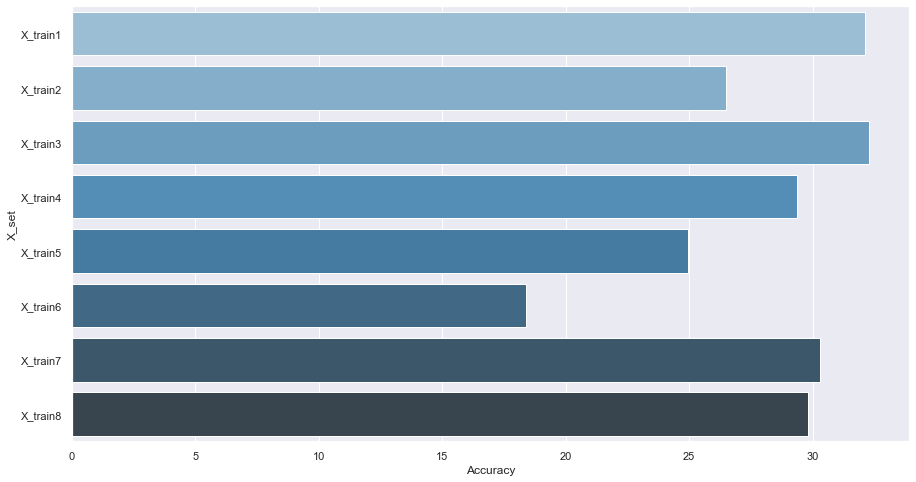

In [138]:
parameters={
            'penalty':['l2','l1','elasticnet']
           }
top=bestPara(parameters, Perceptron(),allSets,y_train)
acc_dict["Perceptron"]=top

Fitting 5 folds for each of 2 candidates, totalling 10 fits
Best estimator :  VotingClassifier(estimators=[('clf1',
                              LogisticRegression(C=10, penalty='l1',
                                                 solver='saga')),
                             ('clf2',
                              QuadraticDiscriminantAnalysis(reg_param=0.7,
                                                            store_covariance=True)),
                             ('clf3', GradientBoostingClassifier(max_depth=1)),
                             ('clf4', SVC(C=1.2))])
Best score :  43.36586218029517 %  with this training set :  2    X_train3
Name: X_set, dtype: object


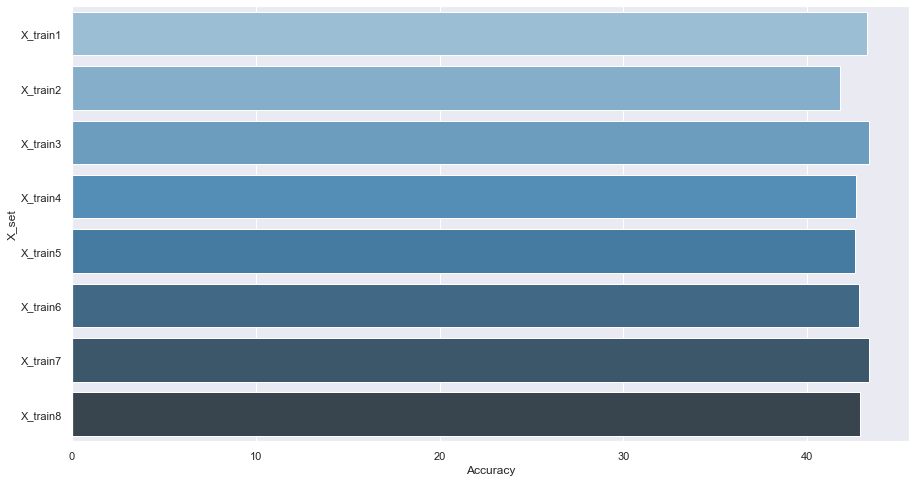

In [144]:
clf1 =  LogisticRegression(C=10, penalty='l1', solver='saga')
clf2 = QuadraticDiscriminantAnalysis(reg_param=0.7, store_covariance=True)
clf3 = GradientBoostingClassifier(max_depth=1)
clf4=SVC(C=1.2)

eclf1 = VotingClassifier(estimators=[
        ('clf1', clf1), ('clf2', clf2), ('clf3', clf3),('clf4',clf4)])
parameters={
            'voting':['hard','soft'],
            }

top=bestPara(parameters, eclf1,allSets,y_train)
acc_dict["Voting"]=top


Fitting 5 folds for each of 30 candidates, totalling 150 fits
[23:27:58] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
Best estimator :  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, enable_categorical=False,
              gamma=0, gpu_id=-1, importance_type=None,
              interaction_constraints='', learning_rate=0.300000012,
              max_delta_step=0, max_depth=1, min_child_weight=2, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=4,
              num_parallel_tree=1, objective='multi:softprob', predictor='auto',
              random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=None,
              subsample=1, 

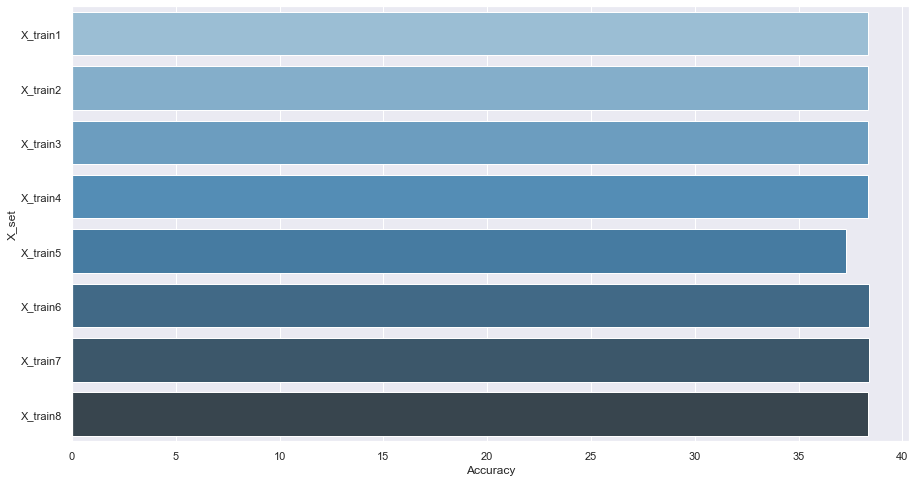

In [364]:
parameters={
            'max_depth':range(1,11),
            'min_child_weight': range(1,4),
            #'eta':[0.3],
            #'subsample': [1],
            #'colsample_bytree': [1],
            # Other parameters
            #'objective':['reg:linear'],
            }
top=bestPara(parameters, xgb.XGBClassifier(),allSets,y_train)
acc_dict["XGBoost"]=top

Fitting 5 folds for each of 8 candidates, totalling 40 fits
Best estimator :  StackingClassifier(estimators=[('clf1',
                                LogisticRegression(C=10, penalty='l1',
                                                   solver='saga')),
                               ('clf2',
                                QuadraticDiscriminantAnalysis(reg_param=0.7,
                                                              store_covariance=True)),
                               ('clf4', SVC(C=1.2))],
                   final_estimator=BaggingClassifier(base_estimator=QuadraticDiscriminantAnalysis(reg_param=0.7,
                                                                                                  store_covariance=True)),
                   stack_method='predict')
Best score :  43.193819740211495 %  with this training set :  1    X_train2
Name: X_set, dtype: object


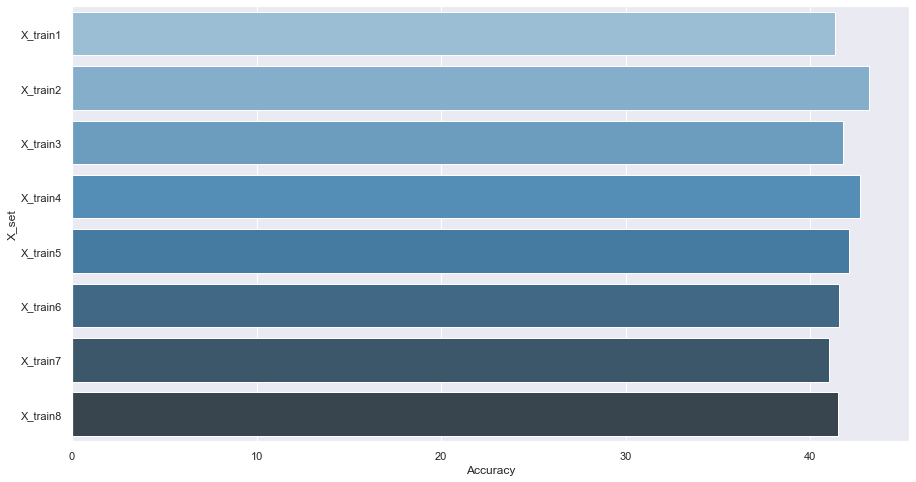

In [78]:
clf1 =  LogisticRegression(C=10, penalty='l1', solver='saga')
clf2 = QuadraticDiscriminantAnalysis(reg_param=0.7, store_covariance=True)
clf3 = GradientBoostingClassifier(max_depth=1)
clf4=SVC(C=1.2)
estimators = [
     ('clf1', clf1), ('clf2', clf2),  ('clf4', clf4)]

clf_stack=StackingClassifier(  estimators=estimators, final_estimator=BaggingClassifier(base_estimator=QuadraticDiscriminantAnalysis(reg_param=0.7, store_covariance=True)))

parameters={
    'stack_method':['auto', 'predict_proba', 'decision_function', 'predict'],
    'passthrough':[True,False]
}
top=bestPara(parameters, clf_stack,allSets,y_train)
acc_dict["Stacking"]=top

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best estimator :  OneVsOneClassifier(estimator=StackingClassifier(estimators=[('clf1',
                                                             LogisticRegression(C=10,
                                                                                penalty='l1',
                                                                                solver='saga')),
                                                            ('clf2',
                                                             QuadraticDiscriminantAnalysis(reg_param=0.7,
                                                                                           store_covariance=True)),
                                                            ('clf4',
                                                             SVC(C=1.2))],
                                                final_estimator=BaggingClassifier(base_estimator=QuadraticDiscriminantAnalysis(reg_param=0.7,


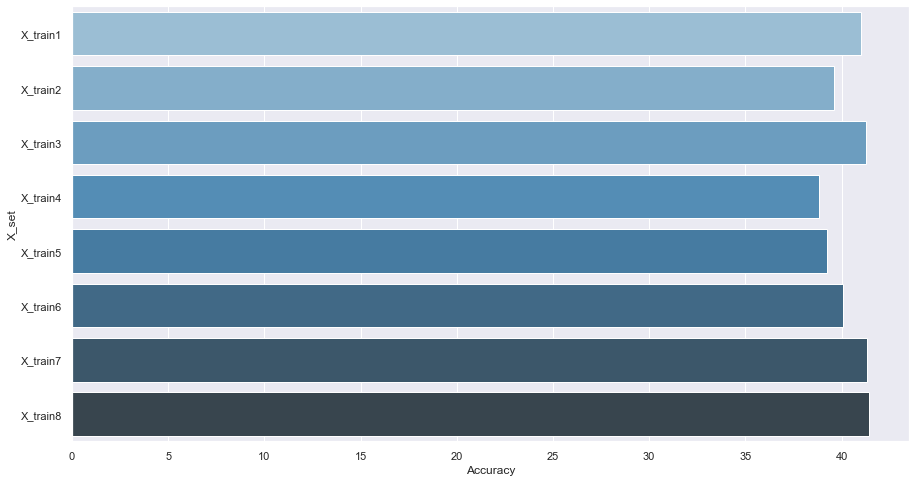

In [81]:
parameters={
            
           }
top=bestPara(parameters, OneVsOneClassifier(StackingClassifier(estimators=[('clf1',LogisticRegression(C=10, penalty='l1',
                                                   solver='saga')),
                               ('clf2',QuadraticDiscriminantAnalysis(reg_param=0.7,store_covariance=True)),
                               ('clf4', SVC(C=1.2))],
                   final_estimator=BaggingClassifier(base_estimator=QuadraticDiscriminantAnalysis(reg_param=0.7,
                                                                                                  store_covariance=True)),
                   stack_method='predict')),allSets,y_train)
acc_dict["OneVsOne"]=top

Fitting 5 folds for each of 1 candidates, totalling 5 fits
Best estimator :  OneVsRestClassifier(estimator=SVC(C=1.2))
Best score :  36.769759450171826 %  with this training set :  4    X_train5
Name: X_set, dtype: object


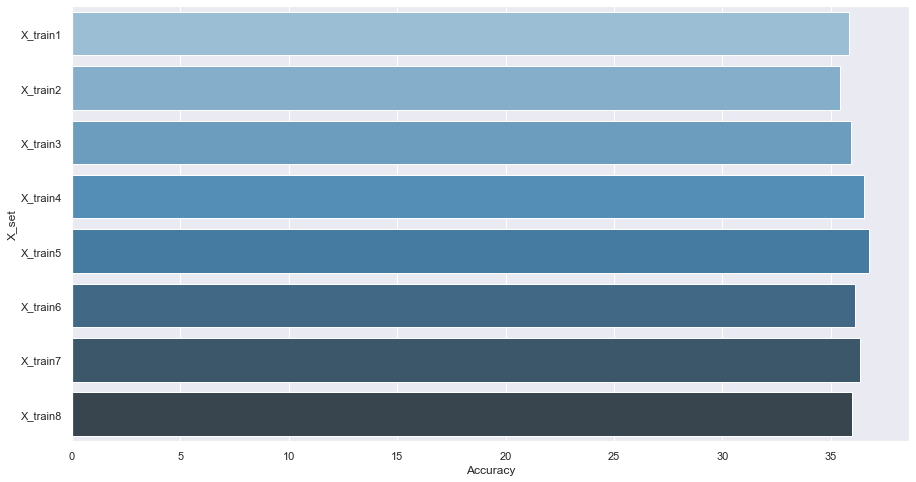

In [100]:
allSets,allTest=allScalers(X_train,X_test)
parameters={
            
           }
top=bestPara(parameters, OneVsRestClassifier(SVC(C=1.2)),allSets,y_train)
acc_dict["OneVsRest"]=top

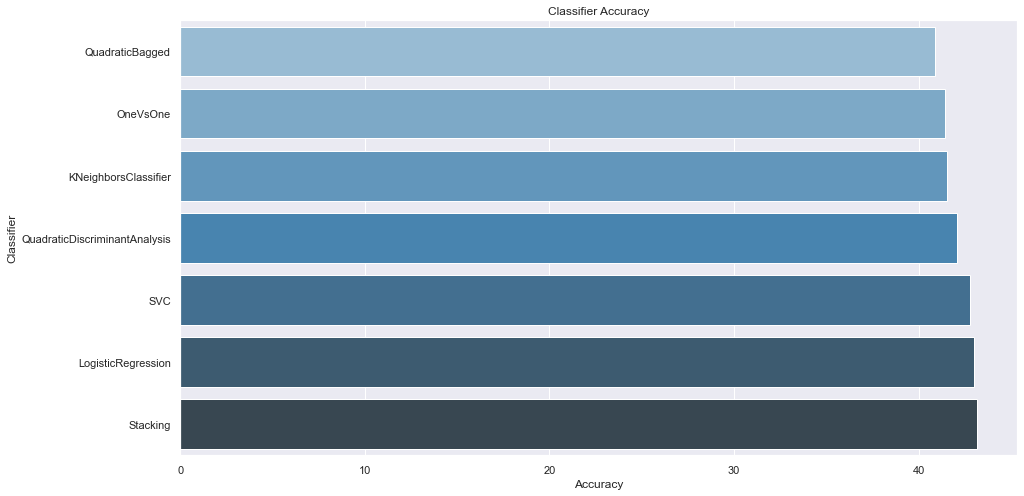

In [82]:

allModels(acc_dict)

In [189]:
import sklearn
sklearn.utils.all_estimators(type_filter='classifier')

[('AdaBoostClassifier', sklearn.ensemble._weight_boosting.AdaBoostClassifier),
 ('BaggingClassifier', sklearn.ensemble._bagging.BaggingClassifier),
 ('BernoulliNB', sklearn.naive_bayes.BernoulliNB),
 ('CalibratedClassifierCV', sklearn.calibration.CalibratedClassifierCV),
 ('CategoricalNB', sklearn.naive_bayes.CategoricalNB),
 ('ClassifierChain', sklearn.multioutput.ClassifierChain),
 ('ComplementNB', sklearn.naive_bayes.ComplementNB),
 ('DecisionTreeClassifier', sklearn.tree._classes.DecisionTreeClassifier),
 ('DummyClassifier', sklearn.dummy.DummyClassifier),
 ('ExtraTreeClassifier', sklearn.tree._classes.ExtraTreeClassifier),
 ('ExtraTreesClassifier', sklearn.ensemble._forest.ExtraTreesClassifier),
 ('GaussianNB', sklearn.naive_bayes.GaussianNB),
 ('GaussianProcessClassifier',
  sklearn.gaussian_process._gpc.GaussianProcessClassifier),
 ('GradientBoostingClassifier',
  sklearn.ensemble._gb.GradientBoostingClassifier),
 ('HistGradientBoostingClassifier',
  sklearn.ensemble._hist_gradi